In [2]:
#-------------------------------------------------------------------------------
#----- Libraries ---------------------------------------------------------------
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt


#-------------------------------------------------------------------------------
#----- Read input ADDA files ---------------------------------------------------
def load_adda_data(base_path, filename_matrix='mueller', filename_eff='CrossSec'):
    base = Path(base_path)
    data = {}

    for size_dir in sorted(base.glob('[0-9][0-9]_amax*')):
        porous = size_dir / 'Porous_Particles'
        for p_dir in sorted(porous.glob('P_*')):
            for comp_dir in sorted(p_dir.glob('comp*')):
                for wl_dir in sorted(comp_dir.glob('[0-9][0-9]_w*')):
                    wl = int(wl_dir.name.split('_')[1].lstrip('w'))
                    for run_idx, run_dir in enumerate(sorted(wl_dir.glob('run*'))):
                        mat_path = run_dir / filename_matrix
                        eff_path = run_dir / filename_eff
                        if not mat_path.is_file() or not eff_path.is_file():
                            continue
                        try:
                            mat = np.genfromtxt(mat_path, dtype=float)[1:]
                            angles = mat[:,0]
                            values = mat[:,1:]
                            S = np.zeros((len(angles), 6))
                            S[:,0] = values[:,0]  
                            S[:,1] = values[:,1]  
                            S[:,2] = values[:,5]  
                            S[:,3] = values[:,10] 
                            S[:,4] = values[:,11] 
                            S[:,5] = values[:,15] 
                            C = np.genfromtxt(eff_path, dtype=float)
                            C_ext = float(C[0, 2])
                            C_abs = float(C[2, 2])
                            C_sca = C_ext - C_abs
                            key = (size_dir.name, p_dir.name, comp_dir.name, wl, run_idx)
                            data[key] = {
                                'angles': angles,
                                'S_matrix': S,
                                'C_ext': C_ext,
                                'C_abs': C_abs,
                                'C_sca': C_sca
                            }
                        except Exception as e:
                            print(f"Error reading {run_dir}: {e}")
    return data


#-------------------------------------------------------------------------------
#----- Read input MSTM files ---------------------------------------------------
def load_mstm_data(base_path):
    base = Path(base_path)
    data = {}

    for size_dir in sorted(base.glob('[0-9][0-9]_amax_*um')):
        fractal_root = size_dir / 'Fractal_Aggregates'
        if not fractal_root.is_dir():
            continue

        for df_dir in sorted(fractal_root.glob('Df_*')):
            df = df_dir.name

            for dat_file in sorted(df_dir.glob('FA_sd_req*_df*_w*.dat')):
                try:
                    wl = int(re.search(r'_w(\d+)\.dat$', dat_file.name).group(1))
                    lines = dat_file.read_text().splitlines()
                except Exception as e:
                    print(f"Error reading {dat_file}: {e}")
                    continue

                # Inicializar valores de radio antes del bucle principal
                vol_cluster_radius = None
                area_mean_sphere_radius = None
                circumscribing_radius = None
                cross_section_radius = None

                # Buscar "volume cluster radius" antes de entrar al bucle
                for j in range(len(lines) - 1):
                    if lines[j].lstrip().lower().startswith("volume cluster radius"):
                        try:
                            radius_values = list(map(float, lines[j + 1].strip().split()))
                            if len(radius_values) == 4:
                                vol_cluster_radius, area_mean_sphere_radius, circumscribing_radius, cross_section_radius = radius_values
                        except:
                            pass
                        break

                comp_idx = 0
                i = 0
                while i < len(lines):
                    line = lines[i]
                    if 'total extinction' in line.lower():
                        comp_idx += 1
                        try:
                            Q_ext, Q_abs, Q_sca = map(float, lines[i + 1].split())
                        except:
                            i += 2
                            continue

                        # Calcular secciones eficaces
                        if cross_section_radius is not None:
                            # Existing area calculation
                            area = np.pi*cross_section_radius**2
                        
                            # Add this factor based on wavelength (λ in µm)
                            factor = (wl/(2*np.pi))**2
                        
                            # Apply full scaling
                            C_ext = Q_ext*area*factor
                            C_abs = Q_abs*area*factor
                            C_sca = Q_sca*area*factor
                        else:
                            C_ext = C_abs = C_sca = None
                        
                        # Buscar matriz de dispersión
                        start_mat = None
                        for j in range(i + 2, len(lines)):
                            if 'theta' in lines[j].lower():
                                start_mat = j + 1
                                break
                        if start_mat is None:
                            i += 1
                            continue

                        mat = []
                        for k in range(start_mat, min(start_mat + 361, len(lines))):
                            try:
                                row = list(map(float, lines[k].split()))
                                if len(row) == 7:
                                    mat.append(row)
                            except:
                                continue
                        if not mat:
                            i += 1
                            continue

                        M = np.array(mat)
                        angles = M[:, 0]
                        matrix_data = M[:, 1:]

                        S = np.zeros((len(angles), 6))
                        for col in range(6):
                            S[:, col] = matrix_data[:, col]
                        #S *= 2*np.pi*C_sca         # Recovery physical units
                        S[:,1:] *= S[:,[0]]      # Transformation between MSTM and ADDA format  

                        #comp = 'comp1' if comp_idx <= 10 else 'comp2'
                        #key = (size_dir.name, df, wl, comp, comp_idx - 1)
                        
                        #----- correction to MSTM data
                        comp = 'comp1' if comp_idx <= 10 else 'comp2'                        
                        if comp == 'comp1':
                            if comp_idx == 1:
                                corrected_idx = 9
                            else:
                                corrected_idx = (comp_idx - 2) % 10
                        else:
                            corrected_idx = comp_idx - 1                        
                        key = (size_dir.name, df, comp, wl, corrected_idx)
                        #-----

                        data[key] = {
                            'angles': angles,
                            'S_matrix': S,
                            'Q_ext': Q_ext,
                            'Q_abs': Q_abs,
                            'Q_sca': Q_sca,
                            'C_ext': C_ext,
                            'C_abs': C_abs,
                            'C_sca': C_sca,
                            'volume_cluster_radius': vol_cluster_radius,
                            'area_mean_sphere_radius': area_mean_sphere_radius,
                            'circumscribing_radius': circumscribing_radius,
                            'cross_section_radius': cross_section_radius
                        }

                        i = start_mat + len(mat)
                    else:
                        i += 1
    return data


#-------------------------------------------------------------------------------
#----- Read input MIE files ----------------------------------------------------
def load_mie_data(base_path, filename_pattern='mie_*.out'):    
    base = Path(base_path)
    data = {}

    for size_dir in sorted(base.glob('[0-9][0-9]_amax_*')):
        solid = size_dir / 'Solid_Sphere'
        if not solid.is_dir():
            continue
        for comp_dir in sorted(solid.glob('comp*')):
            for wl_dir in sorted(comp_dir.glob('[0-9][0-9]_w*')):
                wl_match = re.search(r'w(\d+)', wl_dir.name)
                if not wl_match:
                    continue
                wl = int(wl_match.group(1))
                for idx, mie_file in enumerate(sorted(wl_dir.glob(filename_pattern))):
                    try:
                        with open(mie_file, 'r') as f:
                            lines = f.readlines()
                        C_sca = float(lines[1].split()[0])
                        C_ext = float(lines[2].split()[0])
                        C_abs = C_ext - C_sca
                        mat = np.genfromtxt(lines[5:], dtype=float)
                        angles = mat[:, 0]
                        values = mat[:, 1:]
                        S = np.zeros((len(angles), 6))
                        S[:, 0] = values[:, 0]  
                        S[:, 1] = values[:, 1]   
                        S[:, 2] = values[:, 5]   
                        S[:, 3] = values[:, 10]  
                        S[:, 4] = values[:, 11] 
                        S[:, 5] = values[:, 15] 
                        key = (size_dir.name, 'Solid_Sphere', comp_dir.name, wl, idx)
                        data[key] = {
                            'angles': angles,
                            'S_matrix': S,
                            'C_ext': C_ext,
                            'C_abs': C_abs,
                            'C_sca': C_sca
                        }
                    except Exception as e:
                        print(f"Error reading {mie_file}: {e}")
    return data


#-------------------------------------------------------------------------------
#----- Normalization function --------------------------------------------------
def normalization_function(S_matrix, angles_deg):
    # Convert angles to radians
    theta = np.deg2rad(angles_deg)
    dtheta = np.gradient(theta)

    F11 = S_matrix[:,0]  # F11 is the first row
    integrand = F11*np.sin(theta)
    integral = np.sum(integrand*dtheta)

    if integral == 0:
        raise ValueError("Integral of F11 * sin(theta) is zero. Cannot normalize.")

    S_matrix_normalized = S_matrix/integral
    return S_matrix_normalized


#-------------------------------------------------------------------------------
#----- Size Distribution -------------------------------------------------------
def size_distribution(data_dict, alpha, kk_wav, angles, rr):
    keys = sorted(data_dict.keys())
    nn = len(keys)
    ntheta = len(data_dict[keys[0]]['angles'])
    nF = 6

    PP_raw = np.zeros((nn, ntheta, nF))
    sigma_sca = np.zeros(nn)
    sigma_ext = np.zeros(nn)
    sigma_abs = np.zeros(nn)

    for i, key in enumerate(keys):
        S = data_dict[key]['S_matrix']
        PP_raw[i,:,:] = S
        sigma_sca[i] = data_dict[key]['C_sca']
        sigma_ext[i] = data_dict[key]['C_ext']
        sigma_abs[i] = data_dict[key]['C_abs']

    # Normalize scattering matrices
    PP_N = np.zeros_like(PP_raw)
    for i in range(nn):
        PP_N[i,:,:] = normalization_function(PP_raw[i,:,:], angles_deg=angles)

    # Size distribution function n(r)
    if alpha == 1.0:
        CC = 1.0/np.log(rr[-1]/rr[0])
    else:
        CC = (1.-alpha)/(rr[-1]**(1.-alpha) - rr[0]**(1.-alpha))
    nr = CC*rr**(-alpha)
    
    total_sum = 0.
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        total_sum += 0.5*(nr[ii+1] + nr[ii])*dr
        
    nr *= 1/total_sum     # n(r) normalization equal to 1

    # Averaged optical properties
    sigma_sca_avg = 0.
    sigma_ext_avg = 0.
    sigma_abs_avg = 0.
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        sigma_sca_avg += 0.5*(sigma_sca[ii]*nr[ii] + sigma_sca[ii+1]*nr[ii+1])*dr
        sigma_ext_avg += 0.5*(sigma_ext[ii]*nr[ii] + sigma_ext[ii+1]*nr[ii+1])*dr
        sigma_abs_avg += 0.5*(sigma_abs[ii]*nr[ii] + sigma_abs[ii+1]*nr[ii+1])*dr
    
    albedo_avg = sigma_sca_avg/sigma_ext_avg
    albedo = sigma_sca/sigma_ext

    # Average scattering matrix
    PP_SD = np.zeros((ntheta, nF))
    for ii in range(nn-1):
        dr = rr[ii+1] - rr[ii]
        PP_SD += 0.5*((kk_wav**2)/(4.0*np.pi))*(sigma_sca[ii+1]*PP_N[ii+1,:,:]*nr[ii+1] + sigma_sca[ii]*PP_N[ii,:,:]*nr[ii])*dr
        
    return PP_SD, sigma_sca_avg, sigma_ext_avg, sigma_abs_avg, albedo_avg, nr, sigma_sca, sigma_abs, sigma_ext, albedo


#-------------------------------------------------------------------------------
#----- Plots -------------------------------------------------------------------
def plot(scamat, angles, title_label=True, title='', file_gen=False, file_name='plot_output.eps',
         text=None, color=None, legend=True, num_plots='six'):
    n_plot = len(scamat)
    if text is None:
        text = [''] * n_plot
    if color is None:
        color = ['blue'] * n_plot

    if num_plots == 'two':
        fig, axarr = plt.subplots(1, 2, figsize=(16, 8))
    elif num_plots == 'six':
        fig, axarr = plt.subplots(2, 3, figsize=(18, 8))
        axarr = axarr.flatten()
    else:
        raise ValueError("num_plots must be 'two' or 'six'")

    fig.patch.set_facecolor('white')
    if title_label:
        fig.suptitle(title, color='k')

    labels = ['F11', '-F12/F11', 'F22/F11', 'F33/F11', 'F34/F11', 'F44/F11']
    for i in range(6 if num_plots == 'six' else 2):
        ax = axarr[i]
        ax.axhline(y=0, color='k', linestyle='--')
        for j in range(n_plot):
            F = scamat[j]
            if i == 0:
                y = F[:, 0]  # F11
            else:
                with np.errstate(divide='ignore', invalid='ignore'):
                    y = np.true_divide(F[:, i], F[:, 0])  # Fij / F11
                    y[~np.isfinite(y)] = 0  # replace NaNs and infs
                if i == 1:
                    y = -y  # -F12/F11
            ax.plot(angles[j], y, color=color[j], linestyle='-', label=text[j])
        ax.set_xlabel('Scattering Angle [deg]', fontsize=12)
        ax.set_ylabel(labels[i], fontsize=12)
        ax.grid(True)
        
        if i == 0:
            ax.set_yscale('log')  # Use log scale for F11 
        if i > 0:
            ax.set_ylim(-1.1, 1.1)  # Set y-limits for F12 to F44
        if i == 1 and legend:
            ax.legend()

    if file_gen:
        fig.savefig(file_name, format="eps", dpi=600)
    plt.show()

In [3]:
#-------------------------------------------------------------------------------
#------ Load data --------------------------------------------------------------
adda_data = load_adda_data('.', filename_matrix='mueller', filename_eff='CrossSec')
mstm_data = load_mstm_data('.')
mie_data = load_mie_data('.')

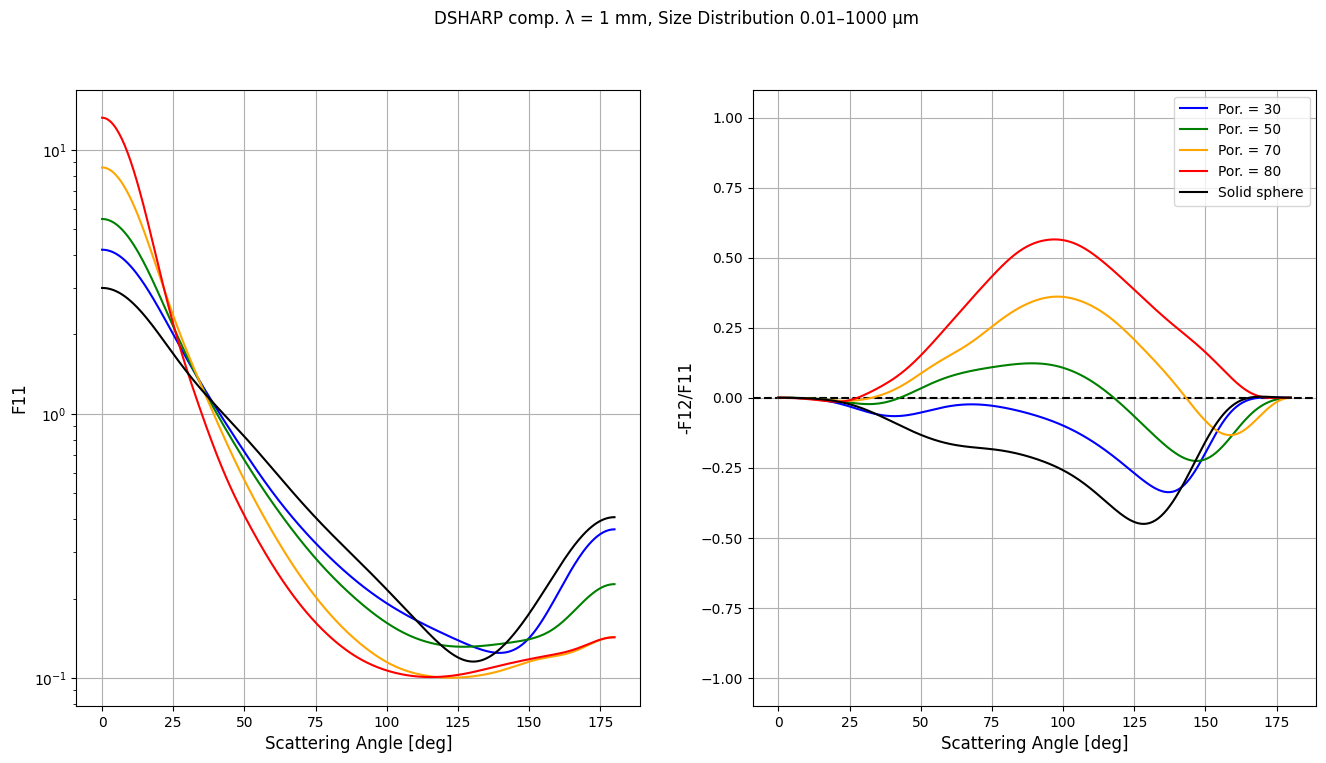

In [14]:
#-------------------------------------------------------------------------------
#----- Average S-matrix for porosities (P_30 to P_80) + MIE at λ=1000 μm -------

# Step 1: Define bins and size distribution radii (45 values)
amax_bins = [
    ("01_amax_01um", 9),
    ("02_amax_1um", 9),
    ("03_amax_10um", 9),
    ("04_amax_100um", 9),
    ("05_amax_1000um", 9)
]

rr_SD = np.array([
    0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,  # 0.01–0.1 μm
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,           # 0.1–1 μm
    1, 2, 3, 4, 5, 6, 7, 8, 9,                             # 1–10 μm
    10, 20, 30, 40, 50, 60, 70, 80, 90,                    # 10–100 μm
    100, 200, 300, 400, 500, 600, 700, 800, 900            # 100–1000 μm
])

# Step 2: Porosities and colors
porosities = ['P_30', 'P_50', 'P_70', 'P_80']
colors = ['blue', 'green', 'orange', 'red']

# Step 3: Initialize containers
scamats = []
angles_list = []
labels = []
color_list = []

# Step 4: Loop through porosities and compute size-averaged S-matrix
for poro, color in zip(porosities, colors):
    all_keys = []
    for bin_name, n_runs in amax_bins:
        keys = [(bin_name, poro, 'comp1', 1000, i) for i in range(n_runs)]
        all_keys.extend(keys)

    if not all(k in adda_data for k in all_keys):
        missing = [k for k in all_keys if k not in adda_data]
        print(f"Skipping {poro} due to missing keys:", missing)
        continue

    subset_data = {k: adda_data[k] for k in all_keys}
    angles = subset_data[all_keys[0]]['angles']
    kk_wav = 2 * np.pi / 1000

    PP_SD, *_ = size_distribution(
        data_dict=subset_data, alpha=3.5, kk_wav=kk_wav, angles=angles, rr=rr_SD
    )
    PP_SD_norm = normalization_function(PP_SD, angles)

    scamats.append(PP_SD_norm)
    angles_list.append(angles)
    labels.append(poro.replace('P_', 'Por. = '))
    color_list.append(color)

# Step 5: Append MIE size-averaged curve (same 45-size distribution)
mie_keys = []
for i in range(45):
    if i < 9:
        folder = "01_amax_01um"
        idx = i
    elif i < 18:
        folder = "02_amax_1um"
        idx = i - 9
    elif i < 27:
        folder = "03_amax_10um"
        idx = i - 18
    elif i < 36:
        folder = "04_amax_100um"
        idx = i - 27
    else:
        folder = "05_amax_1000um"
        idx = i - 36
    mie_keys.append((folder, "Solid_Sphere", "comp1", 1000, idx))

if not all(k in mie_data for k in mie_keys):
    missing = [k for k in mie_keys if k not in mie_data]
    print("Skipping MIE due to missing keys:", missing)
else:
    mie_subset = {k: mie_data[k] for k in mie_keys}
    angles_mie = mie_subset[mie_keys[0]]['angles']
    kk_wav = 2 * np.pi / 1000

    PP_SD_mie, *_ = size_distribution(
        data_dict=mie_subset, alpha=3.5, kk_wav=kk_wav, angles=angles_mie, rr=rr_SD
    )
    PP_SD_mie_norm = normalization_function(PP_SD_mie, angles_mie)

    scamats.append(PP_SD_mie_norm)
    angles_list.append(angles_mie)
    labels.append("Solid sphere")
    color_list.append("black")

# Step 6: Plot F11 and −F12/F11
plot(
    scamats, angles_list,
    title_label=True,
    title='DSHARP comp. λ = 1 mm, Size Distribution 0.01–1000 μm',
    text=labels,
    color=color_list,
    legend=True,
    num_plots='two'
)

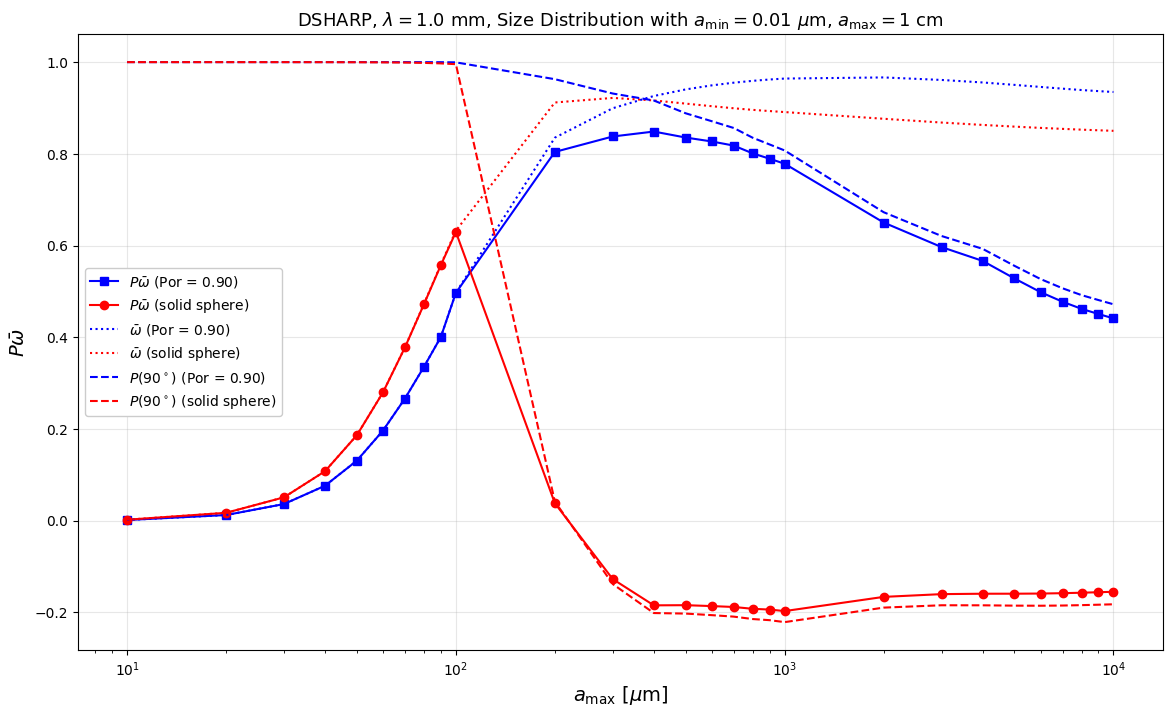

In [7]:
#-------------------------------------------------------------------------------
#----- Effective polarization and albedo vs a_max (ADDA P90 + MIE comp1) -------

# Size bins and corresponding radii
amax_bins = [
    ("03_amax_10um", 9),
    ("04_amax_100um", 9),
    ("05_amax_1000um", 9),
    ("06_amax_10000um", 10)
]
rr_SD = np.array([
    1, 2, 3, 4, 5, 6, 7, 8, 9,         # 1–10 μm
    10, 20, 30, 40, 50, 60, 70, 80, 90, # 10–100 μm
    100, 200, 300, 400, 500, 600, 700, 800, 900,  # 100–1000 μm
    1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000  # 1–10 mm
])
a_max_vals = rr_SD[9:]  # start at 10 μm

# Parameters
alpha = 3.5
wavelength = 1000  # μm
kk_wav = 2 * np.pi / wavelength

# Function to compute polarization and albedo arrays
def compute_pol_albedo(model_data, folder, label):
    polar_90 = []
    albedo_vals = []
    eff_pol_vals = []

    for i in range(10, len(rr_SD) + 1):
        r_subset = rr_SD[:i]
        bin_keys = []
        for j, (bin_name, n_runs) in enumerate(amax_bins):
            offset = sum(n for _, n in amax_bins[:j])
            for k in range(min(n_runs, i - offset)):
                bin_keys.append((bin_name, folder, 'comp1', wavelength, k))

        if not all(key in model_data for key in bin_keys):
            continue

        subset = {key: model_data[key] for key in bin_keys}
        angles = subset[bin_keys[0]]['angles']

        PP_SD, _, _, _, albedo, *_ = size_distribution(
            data_dict=subset,
            alpha=alpha,
            kk_wav=kk_wav,
            angles=angles,
            rr=r_subset
        )
        PP_SD_N = normalization_function(PP_SD, angles)
        j90 = np.argmin(np.abs(angles - 90.0))
        P90 = -PP_SD_N[j90, 1] / PP_SD_N[j90, 0]
        polar_90.append(P90)
        albedo_vals.append(albedo)
        eff_pol_vals.append(P90 * albedo)

    return np.array(polar_90), np.array(albedo_vals), np.array(eff_pol_vals)

# Compute for ADDA P_90
pol_adda, alb_adda, eff_pol_adda = compute_pol_albedo(adda_data, 'P_90', 'adda')

# Compute for MIE solid sphere
pol_mie, alb_mie, eff_pol_mie = compute_pol_albedo(mie_data, 'Solid_Sphere', 'mie')

# Plot
fig = plt.figure(figsize=(14,8))
fig.patch.set_facecolor('white')
plt.semilogx()

plt.plot(a_max_vals, eff_pol_adda, 'b-', marker='s', label=r'$P\bar{\omega}$ (Por = 0.90)')
plt.plot(a_max_vals, eff_pol_mie, 'r-', marker='o', label=r'$P\bar{\omega}$ (solid sphere)')

plt.plot(a_max_vals, alb_adda, 'b:', label=r'$\bar{\omega}$ (Por = 0.90)')
plt.plot(a_max_vals, alb_mie, 'r:', label=r'$\bar{\omega}$ (solid sphere)')

plt.plot(a_max_vals, pol_adda, 'b--', label=r'$P(90^\circ)$ (Por = 0.90)')
plt.plot(a_max_vals, pol_mie, 'r--', label=r'$P(90^\circ)$ (solid sphere)')

plt.xlabel(r'$a_{\rm max}$ [$\mu$m]', fontsize=14)
plt.ylabel(r'$P\bar{\omega}$', fontsize=14)
plt.title(r'DSHARP, $\lambda=1.0$ mm, Size Distribution with $a_{\rm min}=0.01\ \mu$m, $a_{\rm max}=1$ cm', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)
plt.show()
